# Import and Functions

In [0]:
import pandas as pd 
import numpy as np
import seaborn as sns
import requests
from bs4 import BeautifulSoup
import pandas_profiling
import sklearn
import boto3
from boto3 import session

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
#from sklearn.cross_validation import cross_val_score, cross_val_predict, train_test_split, KFold, StratifiedKFold
from sklearn import datasets, linear_model, metrics, preprocessing, pipeline
from sklearn.pipeline import make_union, make_pipeline, Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, accuracy_score, r2_score
from sklearn.neighbors import KNeighborsClassifier

import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy 

import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
import plotly

import re
import sys
import datetime as dt
import time
from time import sleep


!pip install fancyimpute
import fancyimpute
# documentation: https://pypi.org/project/fancyimpute/

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Using TensorFlow backend.


In [0]:
#Exploratory Data Analysis

def get_variable_category(series):
    unique_count = series.nunique(dropna=False)
    total_count = len(series)
    if pd.api.types.is_numeric_dtype(series):
        return 'Numerical'
    elif pd.api.types.is_datetime64_dtype(series):
        return 'Date'
    elif unique_count==total_count:
        return 'Text (Unique)'
    else:
        return 'Categorical'

def print_variable_categories(data):
    for column_name in data.columns:
        print(column_name, ': ', get_variable_category(data[column_name]))
        
def datainspect(dataframe):
    '''Inspect data'''
    print('ROWS AND COLUMNS: \n', dataframe.shape,'\n')
    print('MISSING VALUES: \n', dataframe.isnull().sum(),'\n')
    print('DUPLICATE ROWS \n', dataframe.duplicated().sum(),'\n') 
    print('DATA TYPES: \n', dataframe.dtypes,"\n")
    print('DATAFRAME DESCRIBE: \n \n', dataframe.describe(include='all'),'\n')
    print('UNIQUE VALUES:')
    for item in dataframe:
        print(item, dataframe[item].nunique())
    print('\n')
    print('VARIABLE CATEGORIES:', '\n' )
    print(print_variable_categories(dataframe))


In [0]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

    100% |████████████████████████████████| 993kB 10.7MB/s 


Datasets
Historical Consumption
A selected time series of consumption data for over 200 buildings.

obs_id - An arbitrary ID for the observationaa
SiteId - An arbitrary ID number for the building, matches across datasets
ForecastId - An ID for a timeseries that is part of a forecast (can be matched with the submission file)
Timestamp - The time of the measurement
Value - A measure of consumption for that building
Building Metadata
Additional information about the included buildings.

SiteId - An arbitrary ID number for the building, matches across datasets
Surface - The surface area of the building
Sampling - The number of minutes between each observation for this site. The timestep size for each ForecastId can be found in the separate "Submission Forecast Period" file on the data download page.
BaseTemperature - The base temperature for the building
[DAY_OF_WEEK]IsDayOff - True if DAY_OF_WEEK is not a work day
Historical Weather Data
This dataset contains temperature data from several stations near each site. For each site several temperature measurements were retrieved from stations in a radius of 30 km if available.

Note: Not all sites will have available weather data.

Note: Weather data is available for test periods under the assumption that reasonably accurate forecasts will be available to algorithms that the time that we are attempting to make predictions about the future.

SiteId - An arbitrary ID number for the building, matches across datasets
Timestamp - The time of the measurement
Temperature - The temperature as measured at the weather station
Distance - The distance in km from the weather station to the building in km
Public Holidays
Public holidays at the sites included in the dataset, which may be helpful for identifying days where consumption may be lower than expected.

Note: Not all sites will have available public holiday data.

SiteId - An arbitrary ID number for the building, matches across datasets
Date - The date of the holiday
Holiday - The name of the holiday

# Submission Forecast Period (not using)

**There are no days off for buildings Monday - Thursday**
**Minimal days off for friday, saturday, sunday


In [0]:
submission_forecast_period = 'https://drive.google.com/open?id=1S59Hrh4yduw3Ee_X5yHzHDlSbg-1PkUK'
fluff, id = submission_forecast_period.split('=')
print (id)

1S59Hrh4yduw3Ee_X5yHzHDlSbg-1PkUK


In [0]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('power-laws-forecasting-energy-consumption-submission-forecast-period.csv')  
submission_forecast_period = pd.read_csv('power-laws-forecasting-energy-consumption-submission-forecast-period.csv', sep = ';')
submission_forecast_period.head()

,ForecastId,ForecastPeriodNS
0,18,3600000000000
1,58,900000000000
2,64,900000000000
3,89,900000000000
4,101,900000000000


In [0]:
datainspect(submission_forecast_period)

ROWS AND COLUMNS: 
 (6974, 2) 

MISSING VALUES: 
 ForecastId          0
ForecastPeriodNS    0
dtype: int64 

DUPLICATE ROWS 
 0 

DATA TYPES: 
 ForecastId          int64
ForecastPeriodNS    int64
dtype: object 

DATAFRAME DESCRIBE: 
 
         ForecastId  ForecastPeriodNS
count  6974.000000      6.974000e+03
mean   3487.500000      4.151821e+12
std    2013.364721      1.502076e+13
min       1.000000      9.000000e+11
25%    1744.250000      9.000000e+11
50%    3487.500000      9.000000e+11
75%    5230.750000      9.000000e+11
max    6974.000000      8.640000e+13 

UNIQUE VALUES:
ForecastId 6974
ForecastPeriodNS 3


VARIABLE CATEGORIES: 

ForecastId :  Numerical
ForecastPeriodNS :  Numerical
None


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


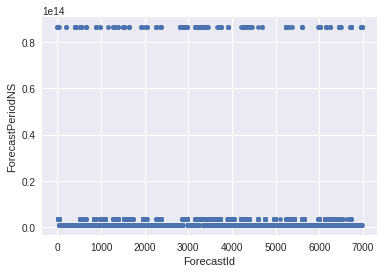

In [0]:
submission_forecast_period.plot(kind='scatter', x='ForecastId', y='ForecastPeriodNS');

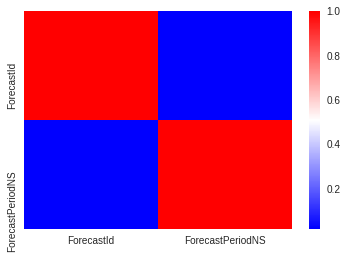

In [0]:
correlation = submission_forecast_period.corr()                            # correlation between ALL variables 
sns.heatmap(correlation, cmap='bwr')

# Submission Format (not using)

In [0]:
submission_format = 'https://drive.google.com/open?id=1B196PxseHWY4DTGgy1dUMqwtm7MFEw_r'
fluff, id = submission_format.split('=')
print (id)

1B196PxseHWY4DTGgy1dUMqwtm7MFEw_r


In [0]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('power-laws-forecasting-energy-consumption-submission-format.csv')  
submission_format = pd.read_csv('power-laws-forecasting-energy-consumption-submission-format.csv', sep = ';')
submission_format.head()

,obs_id,SiteId,Timestamp,ForecastId,Value
0,2535749,143,2017-08-28,3146,0.0
1,7300088,143,2017-08-28,3146,0.0
2,1465337,143,2017-08-28,3146,0.0
3,4747700,143,2017-08-28,3146,0.0
4,6008051,143,2017-08-28,3146,0.0


In [0]:
datainspect(submission_format)

ROWS AND COLUMNS: 
 (1309176, 5) 

MISSING VALUES: 
 obs_id        0
SiteId        0
Timestamp     0
ForecastId    0
Value         0
dtype: int64 

DUPLICATE ROWS 
 0 

DATA TYPES: 
 obs_id          int64
SiteId          int64
Timestamp      object
ForecastId      int64
Value         float64
dtype: object 

DATAFRAME DESCRIBE: 
 
               obs_id        SiteId   Timestamp    ForecastId      Value
count   1.309176e+06  1.309176e+06     1309176  1.309176e+06  1309176.0
unique           NaN           NaN        2269           NaN        NaN
top              NaN           NaN  2016-07-26           NaN        NaN
freq             NaN           NaN        2597           NaN        NaN
mean    3.931478e+06  1.621134e+02         NaN  3.482680e+03        0.0
std     2.271962e+06  9.393814e+01         NaN  2.009967e+03        0.0
min     2.000000e+00  1.000000e+00         NaN  1.000000e+00        0.0
25%     1.963225e+06  8.700000e+01         NaN  1.744000e+03        0.0
50%     3.930562e+0

# Holidays

In [0]:
holidays = 'https://drive.google.com/open?id=1H0TqoTnei1_8DP-ttDsOsJyVkmytQZLG'
fluff, id = holidays.split('=')
print (id)

1H0TqoTnei1_8DP-ttDsOsJyVkmytQZLG


In [0]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('power-laws-forecasting-energy-consumption-holidays.csv')  
holidays = pd.read_csv('power-laws-forecasting-energy-consumption-holidays.csv', sep = ';')
holidays.head()

,Date,Holiday,SiteId
0,2015-05-01,Workers Day,189
1,2015-09-24,Heritage Day,189
2,2017-01-02,New year substitute,190
3,2017-08-09,National Women Day,190
4,2017-12-26,Boxing Day,190


In [0]:
datainspect(holidays)

ROWS AND COLUMNS: 
 (8387, 3) 

MISSING VALUES: 
 Date       0
Holiday    0
SiteId     0
dtype: int64 

DUPLICATE ROWS 
 0 

DATA TYPES: 
 Date       object
Holiday    object
SiteId      int64
dtype: object 

DATAFRAME DESCRIBE: 
 
               Date        Holiday       SiteId
count         8387           8387  8387.000000
unique         346            110          NaN
top     2016-12-26  Christmas Day          NaN
freq           253            707          NaN
mean           NaN            NaN   156.675808
std            NaN            NaN    85.650221
min            NaN            NaN     1.000000
25%            NaN            NaN    87.000000
50%            NaN            NaN   157.000000
75%            NaN            NaN   216.000000
max            NaN            NaN   305.000000 

UNIQUE VALUES:
Date 346
Holiday 110
SiteId 227


VARIABLE CATEGORIES: 

Date :  Categorical
Holiday :  Categorical
SiteId :  Numerical
None


In [0]:
holidays['Holiday'].value_counts().head()

Christmas Day                   707
New year                        707
Easter Monday                   652
All Saints Day                  523
Assumption of Mary to Heaven    521
Name: Holiday, dtype: int64

# Metadata

In [0]:
metadata = 'https://drive.google.com/open?id=1dpwWIs3EyLkaaOSN8ws8gMHgCFsRTYK3'
fluff, id = metadata.split('=')
print (id)

1dpwWIs3EyLkaaOSN8ws8gMHgCFsRTYK3


In [0]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('power-laws-forecasting-energy-consumption-metadata.csv')  
metadata = pd.read_csv('power-laws-forecasting-energy-consumption-metadata.csv', sep = ';')
metadata.head()

,SiteId,Surface,Sampling,BaseTemperature,MondayIsDayOff,TuesdayIsDayOff,WednesdayIsDayOff,ThursdayIsDayOff,FridayIsDayOff,SaturdayIsDayOff,SundayIsDayOff
0,25,2201.924904,15.0,18.0,False,False,False,False,False,True,True
1,49,1046.032846,15.0,18.0,False,False,False,False,False,True,True
2,73,1278.139659,15.0,18.0,False,False,False,False,False,True,True
3,105,15684.678378,10.0,18.0,False,False,False,False,False,True,True
4,117,18772.751947,15.0,18.0,False,False,False,False,False,False,False


In [0]:
datainspect(metadata)

ROWS AND COLUMNS: 
 (267, 11) 

MISSING VALUES: 
 SiteId               0
Surface              0
Sampling             0
BaseTemperature      0
MondayIsDayOff       0
TuesdayIsDayOff      0
WednesdayIsDayOff    0
ThursdayIsDayOff     0
FridayIsDayOff       0
SaturdayIsDayOff     0
SundayIsDayOff       0
dtype: int64 

DUPLICATE ROWS 
 0 

DATA TYPES: 
 SiteId                 int64
Surface              float64
Sampling             float64
BaseTemperature      float64
MondayIsDayOff          bool
TuesdayIsDayOff         bool
WednesdayIsDayOff       bool
ThursdayIsDayOff        bool
FridayIsDayOff          bool
SaturdayIsDayOff        bool
SundayIsDayOff          bool
dtype: object 

DATAFRAME DESCRIBE: 
 
             SiteId       Surface    Sampling  BaseTemperature MondayIsDayOff  \
count   267.000000    267.000000  267.000000       267.000000            267   
unique         NaN           NaN         NaN              NaN              1   
top            NaN           NaN         NaN    

In [0]:
metadata['MondayIsDayOff'].value_counts()


False    267
Name: MondayIsDayOff, dtype: int64

In [0]:
def dayoff(dataframe):
    print('MONDAY IS A DAY OFF: \n', dataframe.MondayIsDayOff.value_counts(),'\n')
    print('TUESDAY IS A DAY OFF: \n', dataframe.TuesdayIsDayOff.value_counts(),'\n')
    print('WEDNESDAY IS A DAY OFF: \n', dataframe.WednesdayIsDayOff.value_counts(),'\n')
    print('THURSDAY IS A DAY OFF: \n', dataframe.ThursdayIsDayOff.value_counts(),'\n')
    print('FRIDAY IS A DAY OFF: \n', dataframe.FridayIsDayOff.value_counts(),'\n')
    print('SATURDAY IS A DAY OFF: \n', dataframe.SaturdayIsDayOff.value_counts(),'\n')
    print('SUNDAY IS A DAY OFF: \n', dataframe.SundayIsDayOff.value_counts(),'\n')

In [0]:
dayoff(metadata)

MONDAY IS A DAY OFF: 
 False    267
Name: MondayIsDayOff, dtype: int64 

TUESDAY IS A DAY OFF: 
 False    267
Name: TuesdayIsDayOff, dtype: int64 

WEDNESDAY IS A DAY OFF: 
 False    267
Name: WednesdayIsDayOff, dtype: int64 

THURSDAY IS A DAY OFF: 
 False    267
Name: ThursdayIsDayOff, dtype: int64 

FRIDAY IS A DAY OFF: 
 False    266
True       1
Name: FridayIsDayOff, dtype: int64 

SATURDAY IS A DAY OFF: 
 True     254
False     13
Name: SaturdayIsDayOff, dtype: int64 

SUNDAY IS A DAY OFF: 
 True     258
False      9
Name: SundayIsDayOff, dtype: int64 



'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


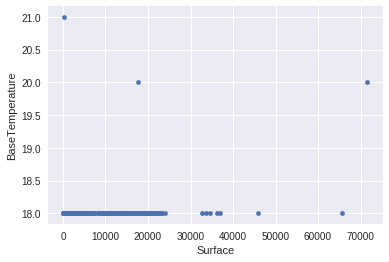

In [0]:
metadata.plot(kind='scatter', x='Surface', y='BaseTemperature');

# Training Data

In [0]:
training_data = 'https://drive.google.com/open?id=1Ri9t0yrf2A99S8Lqy3DwvydP-jmsokeL'
fluff, id = training_data.split('=')
print (id)

1Ri9t0yrf2A99S8Lqy3DwvydP-jmsokeL


In [0]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('power-laws-forecasting-energy-consumption-training-data.csv')  
training_data = pd.read_csv('power-laws-forecasting-energy-consumption-training-data.csv', sep = ';')
training_data.head()

,obs_id,SiteId,Timestamp,ForecastId,Value
0,7385825,295,2016-12-13,6576,120000.030698
1,5463619,295,2016-12-13,6576,54419.278745
2,339589,295,2016-12-13,6576,35351.037846
3,3952414,295,2016-12-13,6576,21932.474447
4,7222988,295,2016-12-14,6576,19379.923271


In [0]:
datainspect(training_data)

ROWS AND COLUMNS: 
 (6559830, 5) 

MISSING VALUES: 
 obs_id            0
SiteId            0
Timestamp         0
ForecastId        0
Value         86601
dtype: int64 

DUPLICATE ROWS 
 0 

DATA TYPES: 
 obs_id          int64
SiteId          int64
Timestamp      object
ForecastId      int64
Value         float64
dtype: object 

DATAFRAME DESCRIBE: 
 
               obs_id        SiteId   Timestamp    ForecastId         Value
count   6.559830e+06  6.559830e+06     6559830  6.559830e+06  6.473229e+06
unique           NaN           NaN        2931           NaN           NaN
top              NaN           NaN  2016-07-08           NaN           NaN
freq             NaN           NaN        7358           NaN           NaN
mean    3.935106e+06  1.620964e+02         NaN  3.482184e+03  3.560104e+05
std     2.271511e+06  9.392171e+01         NaN  2.009486e+03  3.309454e+08
min     0.000000e+00  1.000000e+00         NaN  1.000000e+00  0.000000e+00
25%     1.968046e+06  8.700000e+01         NaN 

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


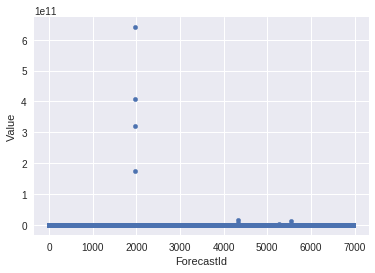

In [0]:
training_data.plot(kind='scatter', x='ForecastId', y='Value');

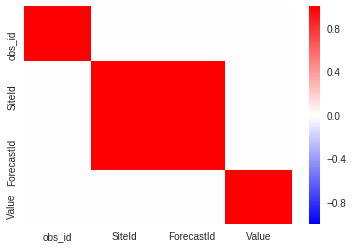

In [0]:
corr = training_data.corr()                            # correlation between ALL variables 
sns.heatmap(corr, cmap='bwr')

**Correlation Pot**



*   forecastId an SiteId are very correlated



**Inspecting the Training Data:**


*   There are no missing values
*   Multiple time-stamps for same Site-id



# Weather

In [0]:
weather = 'https://drive.google.com/open?id=1QZtFjz61NS0Ebbma42LrGtYZFRSsF3Ij'
fluff, id = weather.split('=')
print (id)

1QZtFjz61NS0Ebbma42LrGtYZFRSsF3Ij


In [0]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('power-laws-forecasting-energy-consumption-weather.csv')  
weather = pd.read_csv('power-laws-forecasting-energy-consumption-weather.csv', sep = ';')
weather.head()

,Timestamp,Temperature,Distance,SiteId
0,2016-11-10T14:50:00-05:00,17.0,18.071988,278
1,2016-11-10T17:20:00-05:00,15.0,18.071988,278
2,2016-11-10T18:00:00-05:00,14.6,20.641517,278
3,2016-11-11T18:50:00-05:00,14.0,18.071988,278
4,2016-11-11T23:20:00-05:00,10.0,18.071988,278


In [0]:
datainspect(weather)

ROWS AND COLUMNS: 
 (19911985, 4) 

MISSING VALUES: 
 Timestamp      0
Temperature    0
Distance       0
SiteId         0
dtype: int64 

DUPLICATE ROWS 
 0 

DATA TYPES: 
 Timestamp       object
Temperature    float64
Distance       float64
SiteId           int64
dtype: object 

DATAFRAME DESCRIBE: 
 
                         Timestamp   Temperature      Distance        SiteId
count                    19911985  1.991198e+07  1.991198e+07  1.991198e+07
unique                     485984           NaN           NaN           NaN
top     2016-10-29T22:00:00-04:00           NaN           NaN           NaN
freq                          543           NaN           NaN           NaN
mean                          NaN  1.526614e+01  1.607478e+01  1.668125e+02
std                           NaN  8.191821e+00  8.585157e+00  9.611337e+01
min                           NaN -2.630000e+01  3.895802e-01  1.000000e+00
25%                           NaN  9.400000e+00  7.648476e+00  8.600000e+01
50%         

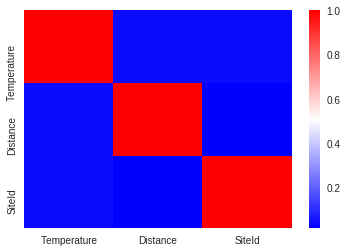

In [0]:
corr2 = weather.corr()                            # correlation between ALL variables 
sns.heatmap(corr2, cmap='bwr')

In [0]:
# Variables
weather_distance = weather[['Distance']]
weather_temp = weather[['Temperature']]
training_data_value = training_data[['Value']]
training_data_ts = training_data[['Timestamp']]
metadata_basetemp = metadata[['BaseTemperature']]
metadata_surface = metadata[['Surface']]

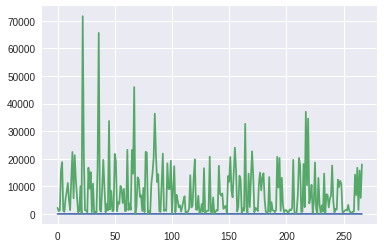

In [0]:
plt.plot(metadata_basetemp)
plt.plot(metadata_surface)